# TRADES FROM PYTHON

In [1]:
import numpy as np  # array
import os
import sys
# import time as timer

Add `pytrades` folder

In [2]:
from pytrades import pytrades
from pytrades import constants as cst
from pytrades import ancillary as anc
set_unit_base = anc.set_unit_base

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
anc.set_rcParams()

## integration parameters

set the integration arguments:  
- `n_body` **mandatory**  
- `duration_check` **mandatory**  
- `t_start` **optional**  
- `t_epoch` **optional**  
- `t_int` **optional**  

In [4]:
t_start = 0.0 # start time of the integration
t_epoch = t_start # reference time of the orbital parameters, could be equal to, earlier or later than `t_start`
t_int   = 1000.0 # total integration time from the start time

n_body = 3 # number of bodies (NOT PLANETS) in the system, that is star + planets
duration_check = 1 # to check or not the duration in this case it is a return flag, 1 means return it

In [5]:
# without setting global value for t_start, t_epoch, t_int:
pytrades.args_init(
    n_body, 
    duration_check,
    t_epoch=None,
    t_start=None,
    t_int=None,
    do_hill_check=False,
    amd_hill_check=False,
    rv_res_gls=False,
)
# n_body (int): Number of bodies.
# duration_check (int): Duration check value.
# t_epoch (int, optional): Optional epoch time value.
# t_start (int, optional): Optional start time value.
# t_int (int, optional): Optional interval time value.
# do_hill_check (bool, optional): Optional flag for Hill check.
# amd_hill_check (bool, optional): Optional flag for AMD Hill check.


## define the orbital parameter of system at the `t_epoch`

In [6]:
# parameter = array([star, planet b, planet c]) = array([body_1, body_2, body_3])
mass   = np.array([1.0, 5.0 * cst.Mears, 54.0 * cst.Mears]) # Masses in Solar unit
radius = np.array([1.0, 2.0 * cst.Rears,  2.5 * cst.Rears]) # Radii in Solar unit
period = np.array([0.0, 11.4453, 22.80988]) # Periods in days
ecc    = np.array([0.0, 0.024, 0.053]) # eccentricities
argp   = np.array([0.0, 202.1, 167.6]) # argument of pericenters in degrees
meana  = np.array([0.0, 3.8, 33.4]) # mean anonalies in degrees
inc    = np.array([0.0, 89.8, 89.9]) # inclinations in degrees
longn  = np.array([0.0, 180.0, 180.0])# longitude of ascending nodes in degrees

Run and compute orbits

In [7]:
time_steps, orbits, stable = pytrades.kelements_to_orbits_full(
    t_epoch,
    t_start,
    t_int,
    mass, radius, 
    period, ecc, argp, meana, inc, longn,
    specific_times=None, # add additional times to compute orbits, e.g. time of RV observations
    step_size=1.0, # define the output stepsize
    n_steps_smaller_orbits=None # number of output steps of the inner planet
)
# sort them
n_steps = len(time_steps)
sort_time = np.argsort(time_steps)
initial_idx = np.arange(0, n_steps, 1).astype(int)[sort_time]
time_steps = time_steps[sort_time]
orbits = orbits[sort_time, :]

Computes the barycentric orbits

In [8]:
bary_orbits, barycentre = pytrades.astrocentric_to_barycentric_orbits(
    mass, orbits
)

Get the RV in m/s for each time step

In [9]:
rvs = pytrades.orbits_to_rvs(mass, orbits)

Get all possible Transit Times with associated durations and keplerian elements.

In [10]:
transiting_body = 1 # all planets
n_transits = (t_int /  period[1:]).astype(int)
n_all_transits = np.sum(n_transits) + (n_body - 1) # star has no transits by definition

transits, durations, lambda_rm, kep_elem, body_flag = pytrades.orbits_to_transits(
    n_all_transits,
    time_steps, mass, radius, orbits,
    transiting_body
)

You can combine the previous three cell in a function to generate one-shot orbits, RVs and transit times.

## Plots

In [11]:
figsize=(4,4)
body_names = ["star", "b", "c"]

Orbits

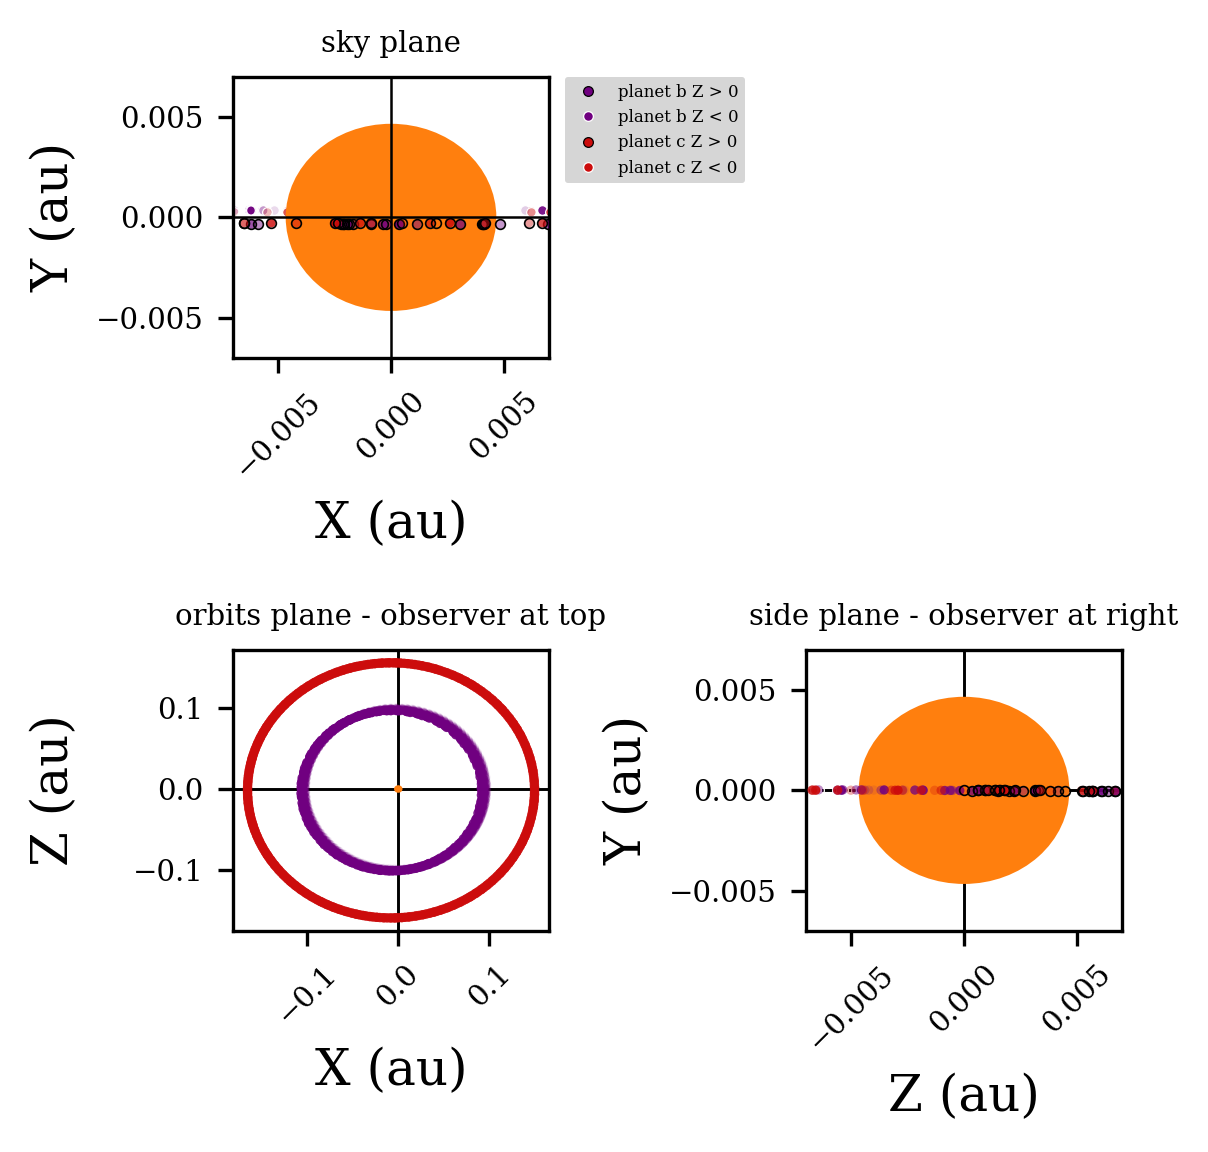

In [12]:
fig = pytrades.base_plot_orbits(
    time_steps,
    orbits,
    radius,
    n_body,
    body_names,
    figsize=figsize,
    sky_scale='star',
    side_scale='star',
    title=None,
    show_plot=True,
)
plt.close(fig)

RVs

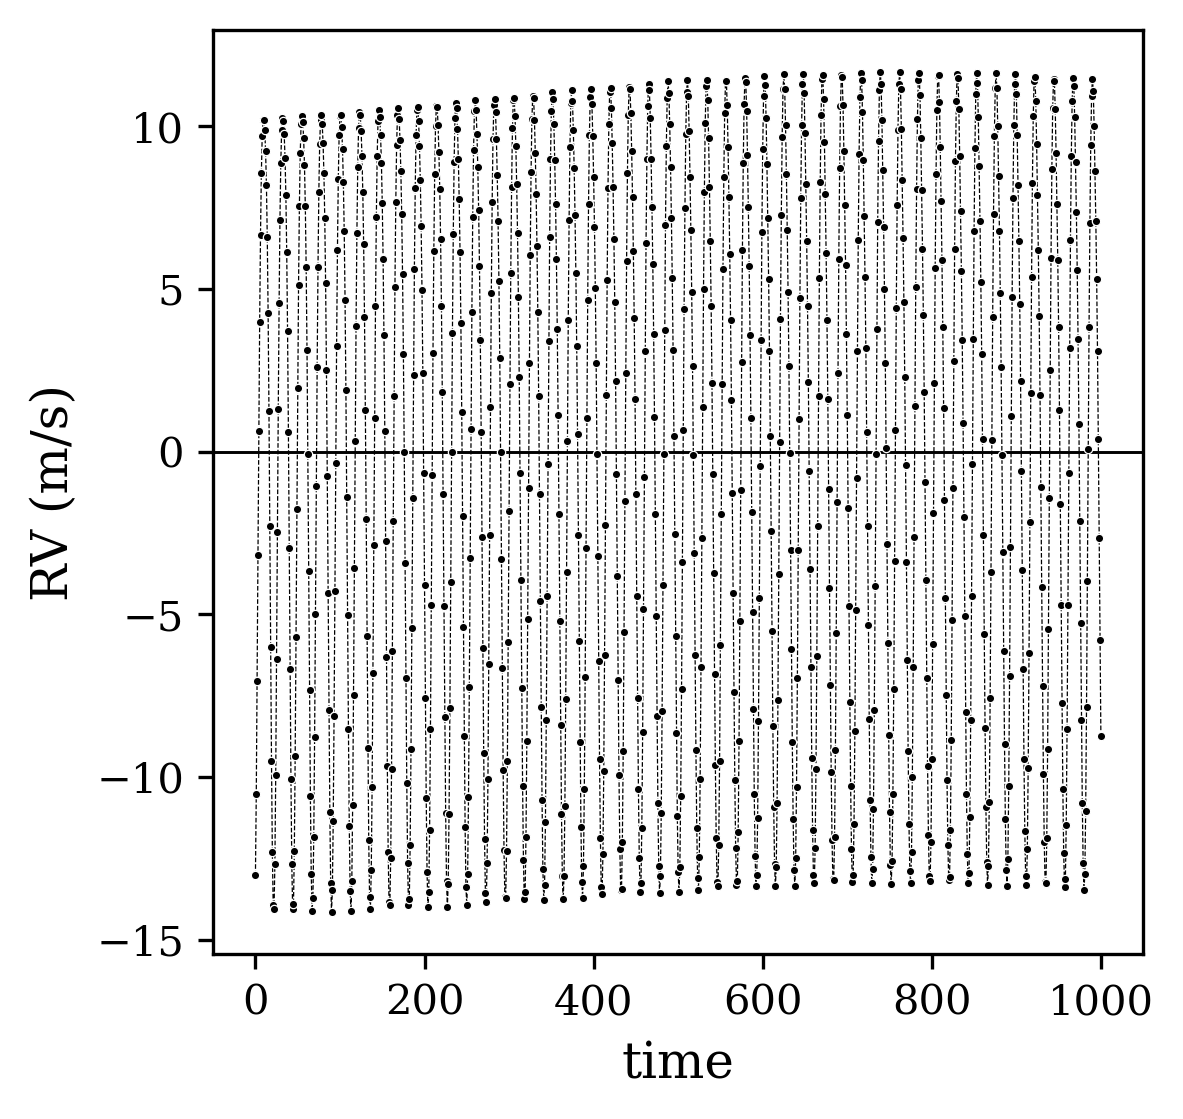

In [13]:
fig = plt.figure(figsize=figsize)
nrows,ncols,irow,icol=1,1,0,0
ax = plt.subplot2grid((nrows,ncols),(irow,icol))

ax.axhline(0.0, color='black', ls='-', lw=0.7, zorder=1)
ax.plot(
    time_steps-t_epoch, rvs,
    color='black',
    marker='o',
    ms=2,
    mec='white',
    mew=0.3,
    ls='--',
    lw=0.3,
    zorder=3
)
ax.set_xlabel("time")
ax.set_ylabel("RV (m/s)")

plt.show()
plt.close(fig)

Transits ==> O-C

=== Planet id 2 == b ===
Pmed =  11.434573300643223  P =  11.4453
Tmed =  499.8504395077821
Tref =  (499.6177298606518, 0.023051040946434627)  Pref =  (11.429805228192441, 0.0009178899261708158)
chi2 = 3.929336864041303 ==> chi2/dof = 0.046227492518132976
chi2 = 7482.000000000002 ==> chi2/dof = 88.02352941176473
A_TTV = semi-amplitude OC = 0.4091450113210726 days
A_TTV =   standard dev OC = 0.21375210767467062 days
A_TTV =   p68.27th abs OC = 0.23038612942952036 days
=== Planet id 3 == c ===
Pmed =  22.809566447312932  P =  22.80988
Tmed =  517.9049487887313
Tref =  (517.9419521593297, 0.005088903597878139)  Pref =  (22.810970132218184, 0.00040044046823155255)
chi2 = 0.04778346191635126 ==> chi2/dof = 0.0011377014741988396
chi2 = 1891.9999999999998 ==> chi2/dof = 45.047619047619044
A_TTV = semi-amplitude OC = 0.061267852066748674 days
A_TTV =   standard dev OC = 0.03333531611339934 days
A_TTV =   p68.27th abs OC = 0.03557256793396991 days


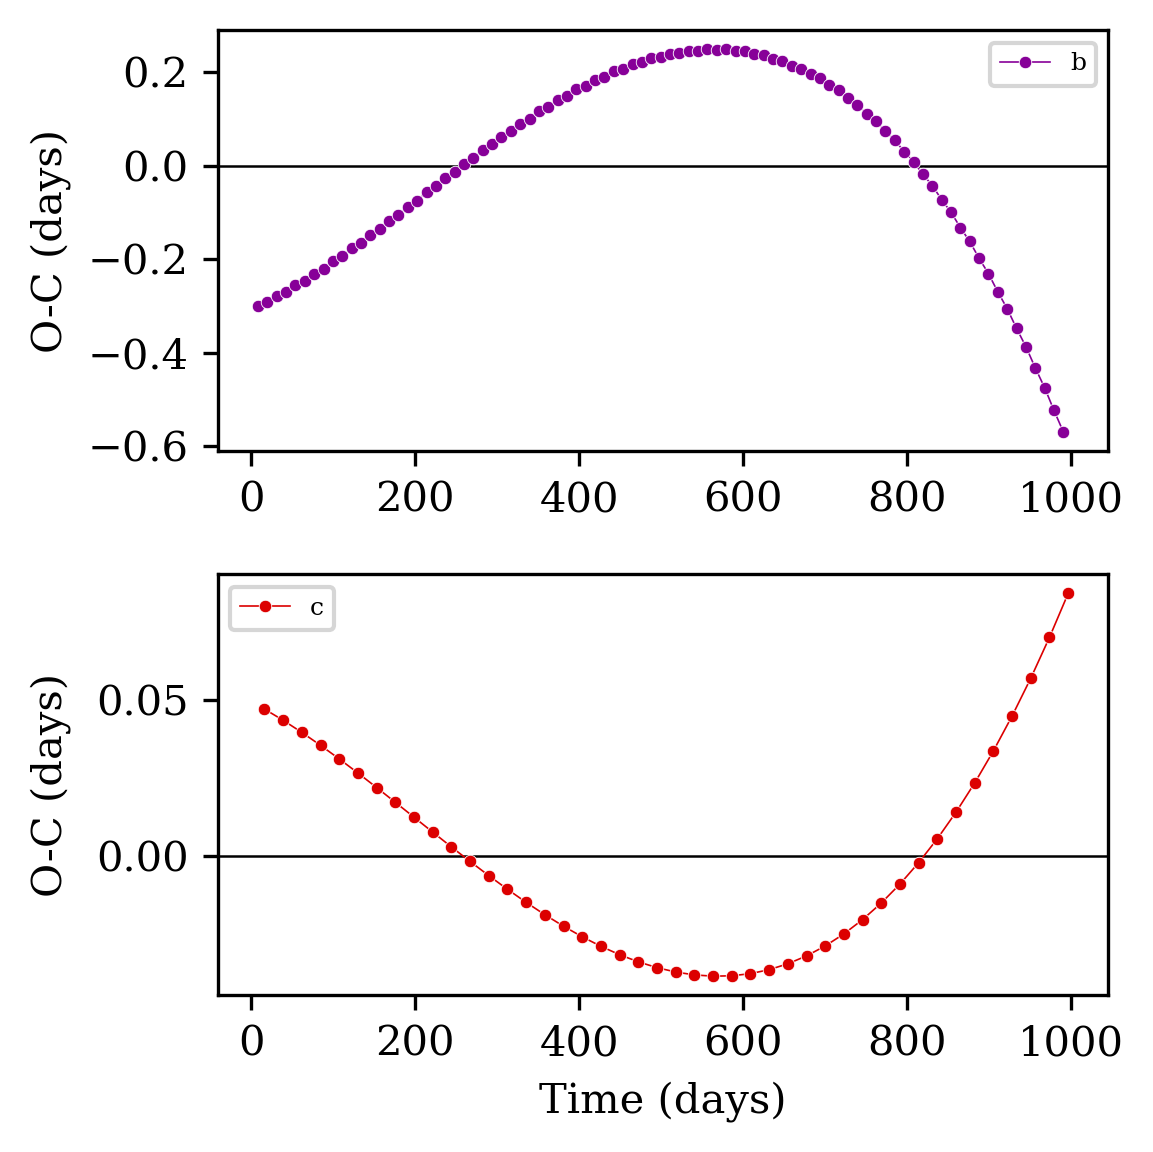

In [ ]:
fig = plt.figure(figsize=figsize)

nrows = n_body - 1
ncols = 1

ms = 3
label_size = 10
tick_size=8
leg_size=6

colors = plt.get_cmap("nipy_spectral")(np.linspace(0.1, 0.9, endpoint=True, num=nrows))

axs = []
xmin = np.inf
xmax = -np.inf

lin_ephem = {}

for i_body in range(1, n_body):
    i_py = i_body - 1
    i_pl = i_body + 1
    print("=== Planet id {} == {} ===".format(i_pl, body_names[i_body]))
    sel = body_flag == i_pl
    tra = transits[sel]
    n_tra = len(tra)

    dt = np.diff(tra)
    Pmed = np.median(dt)
    print("Pmed = ",Pmed," P = ", period[i_body])
    Tmed = tra[n_tra // 2]
    print("Tmed = ", Tmed)
    epo = np.rint( (tra - Tmed) / Pmed )
    Tref, Pref, chi2 = pytrades.linear_fit(epo, tra, ey=None)
    print("Tref = ", Tref, " Pref = ", Pref)
    print("chi2 = {} ==> chi2/dof = {}".format(chi2, chi2/(len(tra)-2))) # this has no meaning due to missing error on T0s
    lin_ephem[i_pl] = {"Tref": Tref[0], "Pref":Pref[0]}
    
    Tlin = Tref[0] + epo * Pref[0]
    oc   = (tra - Tlin)

    ey = np.std(oc, ddof=1)/np.sqrt(len(tra))
    wres = oc/ey
    chi2y = np.dot(wres, wres)
    print("chi2 = {} ==> chi2/dof = {}".format(chi2y, chi2y/(len(tra)-2))) # a chi square like measure of fit
    
    Aoc = 0.5*np.ptp(oc)
    un = set_unit_base("auto", Aoc)
    Aoc_std = np.std(oc, ddof=1)
    Aoc_rms = np.percentile(np.abs(oc), 68.27)
    print("A_TTV = semi-amplitude OC = {} {}".format(Aoc*un[0], un[1]))
    print("A_TTV =   standard dev OC = {} {}".format(Aoc_std*un[0], un[1]))
    print("A_TTV =   p68.27th abs OC = {} {}".format(Aoc_rms*un[0], un[1]))

    ax = plt.subplot2grid((nrows, ncols), (i_py, 0))
    ax.axhline(0.0, color='black', ls='-', lw=0.6, zorder=1)
    ax.plot(
        Tlin, oc*un[0],
        color=colors[i_py],
        marker='o',
        ms=ms,
        mec='white',
        mew=0.2,
        ls='-',
        lw=0.4,
        label=body_names[i_body],
        zorder=5
    )
    ax.legend(loc='best', fontsize=leg_size)
    ax.set_ylabel("O-C ({})".format(un[1]), fontsize=label_size)
    axs.append(ax)
    xl = ax.get_xlim()
    xmin = min(xl[0], xmin)
    xmax = max(xl[1], xmax)
    
ax.set_xlabel("Time (days)", fontsize=label_size)
for ax in axs:
    ax.set_xlim(xmin, xmax)

plt.tight_layout()

fig.align_ylabels(axs)

plt.show()
plt.close(fig)

## Observations

provides RVs info: time, rv (m/s), error_rv (m/s), and data-set id

In [15]:
np.random.seed(seed=42)
# select n_rv from the simulated ones
n_rv = n_steps // 5


idx_rv = np.random.choice(n_steps, size=n_rv, replace=False)
t_rv = time_steps[idx_rv]
rv_obs = rvs[idx_rv]
erv_obs = 0.8 + 1.2*np.random.random(n_rv)

# set a third of rv data from a dataset, and 2/3 from another
rv_setid = np.ones((n_rv)).astype(int)
rv_setid[np.random.choice(n_rv, size=n_rv//3, replace=False)] += 1

set_rv = np.unique(rv_setid)
n_rvset = len(set_rv)
print("n_rv = {} out of {} steps in {} datasets".format(
    n_rv, n_steps, n_rvset
))

n_rv = 200 out of 1001 steps in 2 datasets


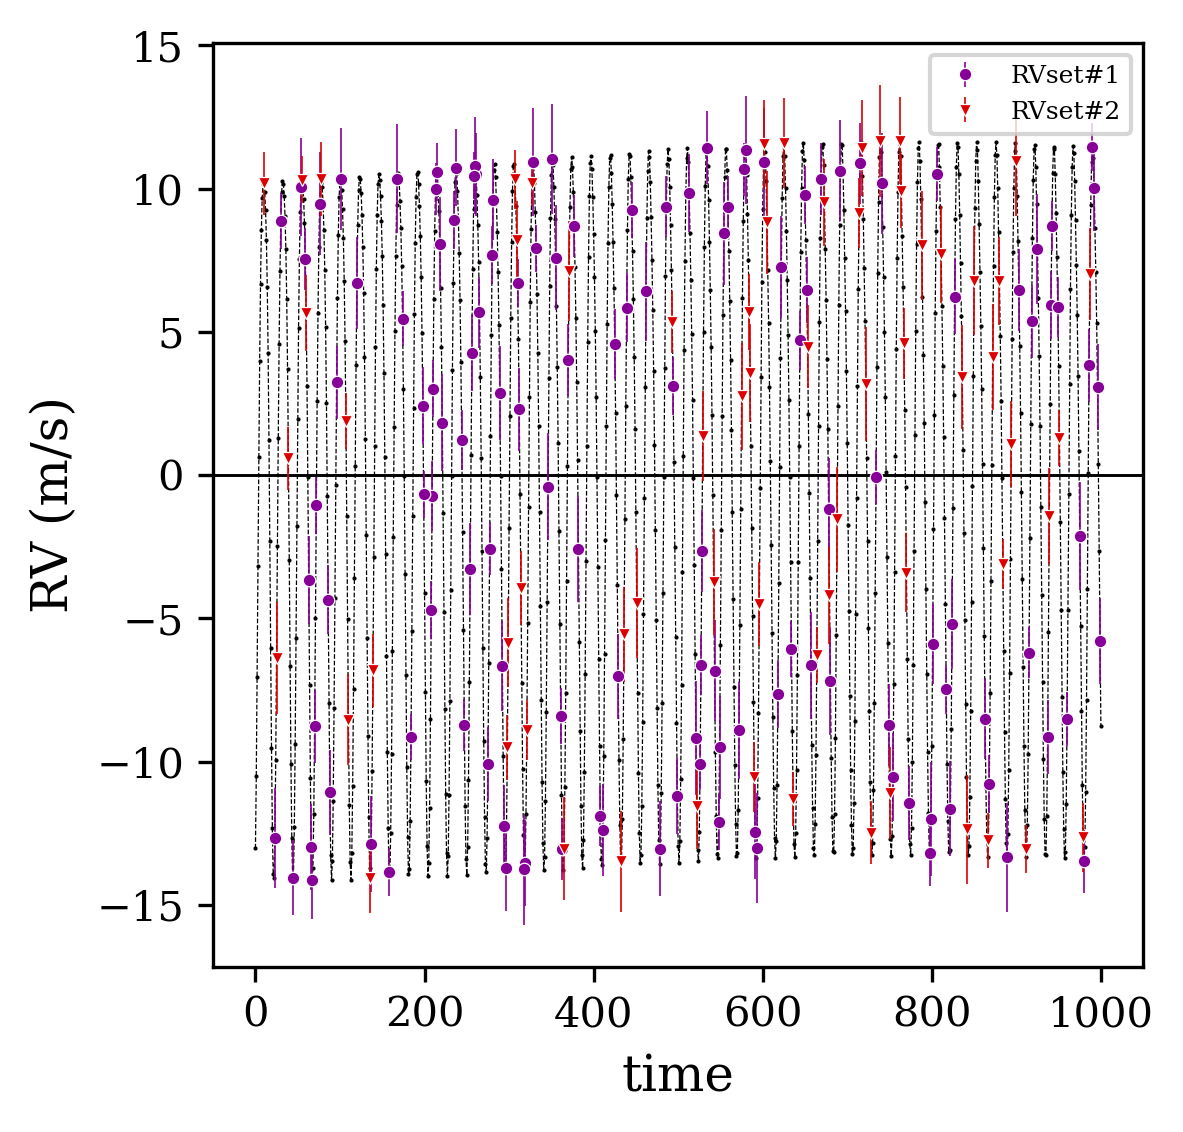

In [16]:
colors = plt.get_cmap("nipy_spectral")(np.linspace(0.1, 0.9, endpoint=True, num=n_rvset))
markers = anc.filled_markers

fig = plt.figure(figsize=figsize)
nrows,ncols,irow,icol=1,1,0,0
ax = plt.subplot2grid((nrows,ncols),(irow,icol))

ax.axhline(0.0, color='black', ls='-', lw=0.7, zorder=1)
ax.plot(
    time_steps-t_epoch, rvs,
    color='black',
    marker='o',
    ms=1,
    mec='None',
    mew=0.3,
    ls='--',
    lw=0.3,
    zorder=3
)
ax.set_xlabel("time")
ax.set_ylabel("RV (m/s)")

for i_s, s in enumerate(set_rv):
    sel = s == rv_setid
    ax.errorbar(
        t_rv[sel]-t_epoch, rv_obs[sel],
        yerr=erv_obs[sel],
        color=colors[i_s],
        marker=markers[i_s],
        ms=3,
        mec='white',
        mew=0.3,
        ls='',
        elinewidth=0.4,
        capsize=0,
        zorder=4,
        label="RVset#{}".format(s)
    )
ax.legend(loc='best', fontsize=6)

plt.show()
plt.close(fig)

deallocation, this is a test, but the next fuction should deallocate RV data before re-allocate them

In [17]:
pytrades.deallocate_rv_dataset()

add the RV dataset to the common variable of TRADES

In [18]:
pytrades.set_rv_dataset(t_rv, rv_obs, erv_obs, rv_setid=rv_setid, n_rvset=n_rvset)

TOs of planet b  
define transit times (T0s) of planet b, that will be the `2nd` body, where the `1st` body is the star!

In [19]:
body_id = 2 # fortran numbering starting with 1 == star
flag_b = body_flag == body_id
n_all_b = np.sum(flag_b)
n_t0b = n_all_b // 4
print("Selected {} T0s out of {}".format(n_t0b, n_all_b))
idx_b = np.random.choice(n_all_b, size=n_t0b, replace=False)
tra_b = transits[flag_b]
t0_b = tra_b[idx_b]
epo_b = np.rint( (t0_b - lin_ephem[body_id]["Tref"]) / lin_ephem[body_id]["Pref"])
et0_b = (20.0 + 140.0* np.random.random(n_t0b))*cst.sec2day
source_b = np.ones(n_t0b).astype(int) # create a vector of source id, set to 1
source_b[n_t0b//2:] = 2  # set the second half to 2

Selected 21 T0s out of 87


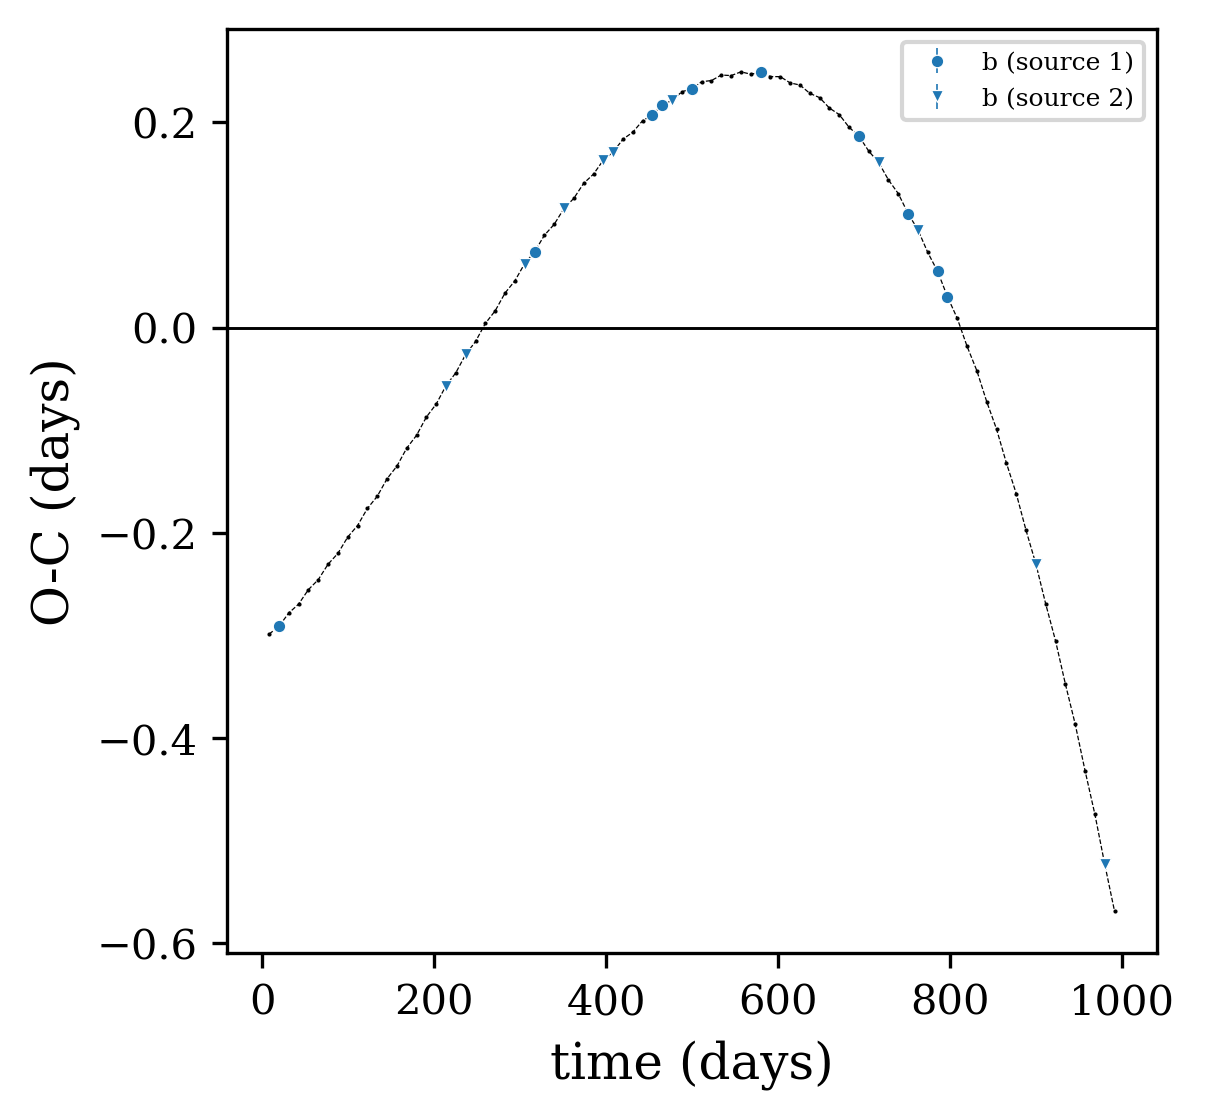

In [20]:
epo_all = np.rint( (tra_b - lin_ephem[body_id]["Tref"]) / lin_ephem[body_id]["Pref"])
Tlin_all = lin_ephem[body_id]["Tref"] + lin_ephem[body_id]["Pref"]*epo_all
oc_all = tra_b - Tlin_all
Aoc = 0.5*np.ptp(oc_all)
un = set_unit_base("auto", Aoc)
Tlin_b = lin_ephem[body_id]["Tref"] + lin_ephem[body_id]["Pref"]*epo_b
oc_b = t0_b - Tlin_b

fig = plt.figure(figsize=figsize)

nrows,ncols,irow,icol=1,1,0,0
ax = plt.subplot2grid((nrows,ncols),(irow,icol))

ax.axhline(0.0, color='black', ls='-', lw=0.7, zorder=1)
ax.plot(
    Tlin_all, oc_all*un[0],
    color='black',
    marker='o',
    ms=1,
    mec='None',
    mew=0.3,
    ls='--',
    lw=0.3,
    zorder=3
)
ax.set_xlabel("time (days)")
ax.set_ylabel("O-C ({})".format(un[1]))

for isrc in np.unique(source_b):
    sel = isrc == source_b
    ax.errorbar(
        Tlin_b[sel], oc_b[sel]*un[0],
        yerr=et0_b[sel],
        color="C0",
        marker=markers[isrc-1],
        ms=3,
        mec='white',
        mew=0.3,
        ls='',
        elinewidth=0.4,
        capsize=0,
        zorder=4,
        label="b (source {})".format(isrc)
    )
ax.legend(loc='best', fontsize=6)

plt.show()
plt.close(fig)

add transits of planet b to the common variable of TRADES

In [21]:
pytrades.set_t0_dataset(body_id, epo_b, t0_b, et0_b, sources_id=None)

T0s planet c  
define T0s for planet c, that is `3rd` body

In [22]:
body_id = 3 # fortran numbering starting with 1 == star
flag_c = body_flag == body_id
n_all_c = np.sum(flag_c)
n_t0c = n_all_c // 4
print("Selected {} T0s out of {}".format(n_t0c, n_all_c))
idx_c = np.random.choice(n_all_c, size=n_t0c, replace=False)
tra_c = transits[flag_c]
t0_c = tra_c[idx_c]
epo_c = np.rint( (t0_c - lin_ephem[body_id]["Tref"]) / lin_ephem[body_id]["Pref"])
et0_c = (20.0 + 140.0* np.random.random(n_t0c))*cst.sec2day

Selected 11 T0s out of 44


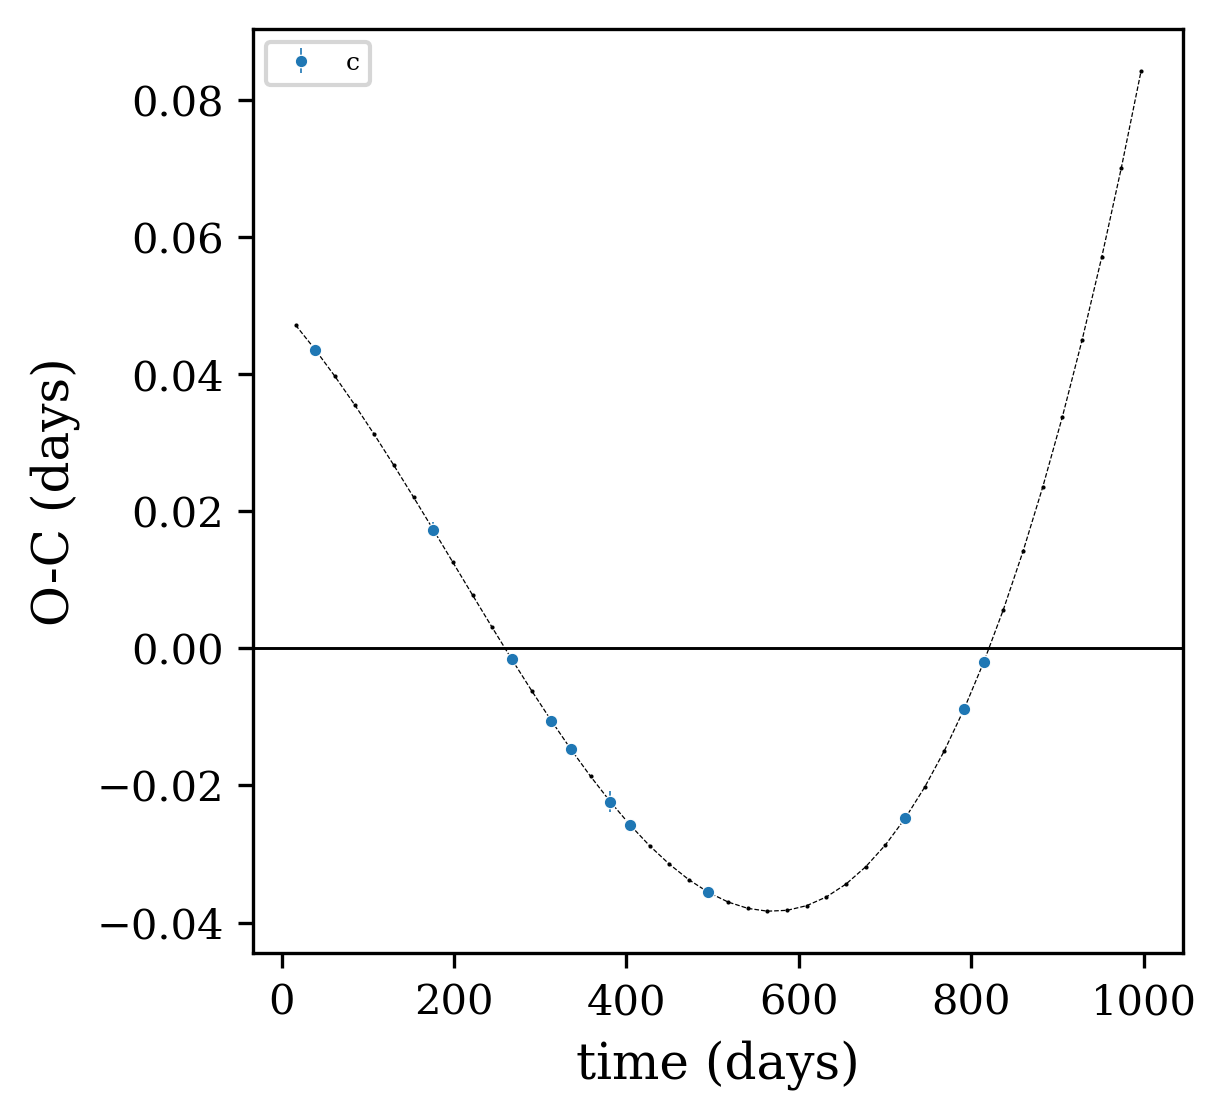

In [23]:
epo_all = np.rint( (tra_c - lin_ephem[body_id]["Tref"]) / lin_ephem[body_id]["Pref"])
Tlin_all = lin_ephem[body_id]["Tref"] + lin_ephem[body_id]["Pref"]*epo_all
oc_all = tra_c - Tlin_all
Aoc = 0.5*np.ptp(oc_all)
un = set_unit_base("auto", Aoc)
Tlin_c = lin_ephem[body_id]["Tref"] + lin_ephem[body_id]["Pref"]*epo_c
oc_c = t0_c - Tlin_c

fig = plt.figure(figsize=figsize)

nrows,ncols,irow,icol=1,1,0,0
ax = plt.subplot2grid((nrows,ncols),(irow,icol))

ax.axhline(0.0, color='black', ls='-', lw=0.7, zorder=1)
ax.plot(
    Tlin_all, oc_all*un[0],
    color='black',
    marker='o',
    ms=1,
    mec='None',
    mew=0.3,
    ls='--',
    lw=0.3,
    zorder=3
)
ax.set_xlabel("time (days)")
ax.set_ylabel("O-C ({})".format(un[1]))

ax.errorbar(
    Tlin_c, oc_c*un[0],
    yerr=et0_c,
    color="C0",
    marker=markers[0],
    ms=3,
    mec='white',
    mew=0.3,
    ls='',
    elinewidth=0.4,
    capsize=0,
    zorder=4,
    label="c"
)
ax.legend(loc='best', fontsize=6)

plt.show()
plt.close(fig)

add transits of planet c to the common variable of TRADES

In [24]:
pytrades.set_t0_dataset(body_id, epo_c, t0_c, et0_c)

if you try to repeat the `set_t0_dataset` it will deallocate and reallocate the data ... hopefully :)

In [25]:
pytrades.set_t0_dataset(body_id, epo_c, t0_c, et0_c) # yes it works...

it is needed to define a flag vector to identify which bodies has to transit or not, the `star` does not, so first element has to be flagged to `False`.  
If you don't know if they transit or not set `star` to `False`, all `other bodies` to `True`.

In [26]:
transit_flag = np.array([False, True, True])

## Complete run (computes orbits, RVs, transits):  

**input:**

- `t_start`: start time of the integration  
- `t_epoch`: reference time of the orbital parameters, it could be equal to, earlier, or later than `t_start`  
- `t_int`: integration time in days from t_start, remember that `t_start + t_int` has to cover all your observations!  
- `mass`: masses of the bodies (star, planet 1, planet 2, etc) in Msun  
- `radius`: radii of the bodies (star, planet 1, planet 2, etc) in Rsun  
- `period`: periods of the bodies (0, planet 1, planet 2, etc) in days  
- `ecc`: eccentricities of the bodies (0, planet 1, planet 2, etc)  
- `argp`: argument of pericenter/periastron of the bodies (0, planet 1, planet 2, etc) in deg, if ecc=0 set it to 90°  
- `meana`: mean anamolies of the bodies (0, planet 1, planet 2, etc) in deg  
- `inc`: inclination of the bodies (0, planet 1, planet 2, etc) in deg, remember inc=90° means the planet pass exact at the center of the star  
- `longn`: longitude of the ascending nodes of the bodies (0, planet 1, planet 2, etc) in deg, set for a reference body to 180°, if unknown set 180° for all the planets  
- `transit_flag`: flag of the transiting bodies, suggested default: `[False, True, True, ...]`  

**output:**  

- `rv_sim(n_rv)` in m/s  
- `body_tra_flag_sim(n_T0s)` id of the body, from 2 to n_body, of each transit time    
- `epo_sim(n_T0s)` epoch number of the transit w.r.t. the linear ephemeris of the corresponding body  
- `transits_sim(n_T0s)` simulated transit time in days corresponding to epoch and body at the same row  
- `durations_sim(n_T0s)` simulated Total Duration as T4 - T1 in minutes
- `lambda_rm_sim` simulated spin-orbit misaligned at each transit time in degrees  
- `kep_elem_sim(n_T0s, 8)` keplerian elements for each transit time, each column an orbital elements:  
    - `kep_elem_sim(, 0)` period in days  
    - `kep_elem_sim(, 1)` semi-major axis in au  
    - `kep_elem_sim(, 2)` eccentricity  
    - `kep_elem_sim(, 3)` inclination in degrees  
    - `kep_elem_sim(, 4)` mean anomaly in degrees  
    - `kep_elem_sim(, 5)` argument of pericenter in degrees  
    - `kep_elem_sim(, 6)` true anomaly in degrees  
    - `kep_elem_sim(, 7)` longitude of ascending node in degrees
- `stable` simulation stable is True/1 else is False/0  

let's run the orbital integration and get the simulated RVs and T0s (with orbital elements)

In [27]:
(
    rv_sim, 
    body_tra_flag_sim, 
    epo_sim, 
    transits_sim, 
    durations_sim, 
    lambda_rm_sim, 
    kep_elem_sim, 
    stable
) = pytrades.kelements_to_rv_and_t0s(
    t_start,
    t_epoch,
    t_int,
    mass,
    radius,
    period,
    ecc,
    argp,
    meana,
    inc,
    longn,
    transit_flag,
)

In [28]:
# print("# {:>12s} {:>9s} {:>9s}".format("time", "RVobs","RVsim_mps"))
# for to, rvo, rvs in zip(t_rv, rv_obs, rv_sim):
#     print("  {:12.5f} {:9.3f} {:9.3f}".format(to, rvo, rvs))

In [29]:
# head = "body epoch T0o T0s T14_min".split()
# print("# {:>4s} {:>5s} {:>12s} {:>12s} {:>7s}".format(*head))
# for ibd, epo, t0o, t0s, t14 in zip(body_T0_sim, epo_sim, np.concatenate((t0_b, t0_c)), t0_sim, t14_sim):
#     print("  {:4d} {:5.0f} {:12.5f} {:12.5f} {:7.3f}".format(ibd, epo, t0o, t0s, t14))

## Try deallocating some data and/or run with/without one dataset kind

try to deallocate a T0s dataset: planet c

In [30]:
pytrades.deallocate_t0_dataset(3)

In [31]:
(
    rv_sim, 
    body_tra_flag_sim, 
    epo_sim, 
    transits_sim, 
    durations_sim, 
    lambda_rm_sim, 
    kep_elem_sim, 
    stable
) = pytrades.kelements_to_rv_and_t0s(
    t_start,
    t_epoch,
    t_int,
    mass,
    radius,
    period,
    ecc,
    argp,
    meana,
    inc,
    longn,
    transit_flag,
)

In [32]:
# print("# {:>12s} {:>9s} {:>9s}".format("time", "RVobs","RVsim_mps"))
# for to, rvo, rvs in zip(t_rv, rv_obs, rv_sim):
#     print("  {:12.5f} {:9.3f} {:9.3f}".format(to, rvo, rvs))

In [33]:
# head = "body epoch T0o T0s T14_min".split()
# print("# {:>4s} {:>5s} {:>12s} {:>12s} {:>7s}".format(*head))
# for ibd, epo, t0o, t0s, t14 in zip(body_T0_sim, epo_sim, np.concatenate((t0_b, t0_c)), t0_sim, t14_sim):
#     print("  {:4d} {:5.0f} {:12.5f} {:12.5f} {:7.3f}".format(ibd, epo, t0o, t0s, t14))

testing only RVs output

In [34]:
rv_sim = pytrades.kelements_to_rv(
    t_start,
    t_epoch,
    t_int,
    mass,
    radius,
    period,
    ecc,
    argp,
    meana,
    inc,
    longn,
)

In [35]:
# print("# {:>12s} {:>9s} {:>9s}".format("time", "RVobs","RVsim_mps"))
# for to, rvo, rvs in zip(t_rv, rv_obs, rv_sim):
#     print("  {:12.5f} {:9.3f} {:9.3f}".format(to, rvo, rvs))

testing only T0s output  
re-adding T0s of planet c

In [36]:
pytrades.set_t0_dataset(body_id, epo_c, t0_c, et0_c)

In [37]:
(
    body_tra_flag_sim,
    epo_sim, 
    transits_sim, 
    durations_sim, 
    lambda_rm_sim, 
    kep_elem_sim,
    stable
)= pytrades.kelements_to_t0s(
    t_start,
    t_epoch,
    t_int,
    mass,
    radius,
    period,
    ecc,
    argp,
    meana,
    inc,
    longn,
    transit_flag,
)

In [38]:
# head = "body epoch T0o T0s T14_min".split()
# print("# {:>4s} {:>5s} {:>12s} {:>12s} {:>7s}".format(*head))
# for ibd, epo, t0o, t0s, t14 in zip(body_T0_sim, epo_sim, np.concatenate((t0_b, t0_c)), t0_sim, t14_sim):
#     print("  {:4d} {:5.0f} {:12.5f} {:12.5f} {:7.3f}".format(ibd, epo, t0o, t0s, t14))

## To be used with optimizer/MCMC: create a log-likelihood function such as:

In [39]:
def fit_to_physical(fit_pars):
    
    # here convert the fit_pars into:
    # mass of all bodies (star, b, c, ...) in Msun,
    # radius Rsun,
    # period in day,
    # ecc, # if you have circular orbits set ecc = np.zeros((n_body))
    # argp in deg,
    # meana in deg,
    # inc deg, # fix inclinations: inc = inc_deg
    # longn deg, # longn = np.array([0.0, 180.0, 180.0]) for 3 bodies
    # use GLOBAL!
    
    return mass, radius, period, ecc, argp, meana, inc, longn 

def loglike_function(fit_pars):
    
    mass, radius, period, ecc, argp, meana, inc, longn = fit_to_physical(fit_pars)
    
    (
        rv_sim, 
        body_tra_flag_sim, 
        epo_sim, 
        transits_sim, 
        durations_sim, 
        lambda_rm_sim, 
        kep_elem_sim, 
        stable
    ) = pytrades.kelements_to_rv_and_t0s(
        t_start, # GLOBAL
        t_epoch, # GLOBAL
        t_int, # GLOBAL
        mass, radius, period, ecc, argp, meana, inc, longn,
        transit_flag, # GLOBAL
    )
    
    ## RV
    lnL_rv = 0
    # add trends, gp to rv_sim
    rv = rv_sim + trend_rv + gp_rv
    res_rv = rv_obs - rv # rv_obs GLOBAL
    # lnL_rv = f(res_rv, jitter, etc)
    
    ## T0s
    lnL_T0 = 0
    res_T0b = t0_b - transits_sim[body_tra_flag_sim==2] # t0_b GLOBAL
    res_T0c = t0_c - transits_sim[body_tra_flag_sim==3] # t0_c GLOBAL
    # lnL_T0 = g(res_T0b, res_T0c)
    
    lnL = lnL_rv + lnL_T0
    
    return lnL